<a href="https://colab.research.google.com/github/KoreanJD/crawlingStock/blob/main/main_all_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update && apt-get install swig cmake
!pip install box2d-py
!pip install "stable-base|lines3[extra]>=2.0.0a4"
!pip install stable_baselines3
!pip install shimmy
!pip install optuna
pip install stable-baselines3[extra]

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,738 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,513 kB]
Fetched 4,635 kB in 3s (1,356 kB/s)
Reading package lists... Done
W: Skipping acquire of

In [ ]:
#import lib
import gymnasium as gym
import numpy as np
import pandas as pd
import yfinance as yf
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
import time

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback

import matplotlib.pyplot as plt
import os
from stable_baselines3.common.results_plotter import load_results, ts2xy


In [ ]:
class StockPortfolioEnv(gym.Env):
    """
    Generate a stock portfolio environment for reinforcement learning.
    basically this env super by gym of gymnasium. therfore we follow the structure of gym.env
    data : pandas dataframe type. it is columns of ticker, index is itme series
    """
    def __init__(self, data, initial_balance=10000000):
        super(StockPortfolioEnv, self).__init__()
        self.data = data
        self.initial_balance = initial_balance
        self.current_step = 0

        # 포트폴리오 관련 변수
        self.balance = initial_balance
        self.portfolio = [0] * len(data.columns)  # 각 회사에 대한 주식 보유 수량
        self.current_company = 0  # 현재 선택된 회사

        # 행동 공간 정의: Hold, Buy, Sell, Select company
        # self.action_space = gym.spaces.Discrete(4)
        self.action_space = gym.spaces.MultiDiscrete([3, len(data.columns)])

        # 관측 공간 정의: 모든 회사의 현재 가격 및 지표
        self.observation_space = gym.spaces.Box(low=0, high=np.inf, shape=(len(data.columns) * 2,), dtype=np.float32)

    def reset(self, seed = 42, options = None):
        # super().reset(seed=seed)
        self.current_step = 0
        self.balance = self.initial_balance
        self.portfolio = [0] * len(self.data.columns)
        self.current_company = 0

        return self._next_observation(), {}

    def _next_observation(self):
        current_prices = self.data.iloc[self.current_step].values

        portfolio_values = np.array(self.portfolio) * current_prices

        return np.concatenate((current_prices,portfolio_values), axis=0)

    def step(self, action):
        action_type, company = action

        # action_type과 company의 유효성 체크
        if action_type not in [0, 1, 2]:
            raise ValueError(f"Invalid action_type: {action_type}")
        if company < 0 or company >= len(self.data.columns):
            raise ValueError(f"Invalid company index: {company}")

        current_prices = self.data.iloc[self.current_step].values
        current_price = current_prices[company]

        self.current_step += 1
        done = self.current_step >= len(self.data) - 1

        if action_type == 0:  # Hold
            pass

        elif action_type == 1:  # Buy
            if self.balance >= current_price:
                self.portfolio[company] += 1
                self.balance -= current_price

        elif action_type == 2:  # Sell
            if self.portfolio[company] > 0:
                self.portfolio[company] -= 1
                self.balance += current_price


        # 포트폴리오의 총 가치 계산
        total_value = self.balance + np.sum(np.array(self.portfolio) * current_prices)
        # reward = total_value - self.initial_balance
        reward = (total_value - self.initial_balance)*10

        # print(f"Step: {self.current_step}, Action: {action}, Total Value: {total_value}, Reward: {reward}")

        obs = self._next_observation()

       # 종료 플래그와 추가 정보 반환
        terminated = bool(done)  # 자연스럽게 종료될 경우
        truncated = False  # 에피소드가 강제 중단되는 상황을 가정하지 않음
        info = {}
        # obs, reward, terminated, truncated, info
        return obs, reward, terminated, truncated, info

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Fetch stock data from Yahoo Finance
def fetch_stock_data(tickers, start_date='2003-01-01', end_date='2023-01-01'):
    df_dict = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start_date, end=end_date)
        df_dict[ticker] = df
    return df_dict

In [ ]:
# Define list of companies and fetch their data
company_list = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "TSLA", "NVDA", "NFLX", "INTC", "AMD", "BA", "JPM", "V", "DIS", "PYPL", "IBM", "ORCL", "KO", "PEP", "MCD"]
# return to dict type, each dict have dataframe type
df_dict = fetch_stock_data(company_list)

#concat dataframe of all ticker
df = pd.DataFrame()
for ticker in company_list:
  df = pd.concat([df, df_dict[ticker]['Close'].transpose()])
# basically each item should be null with total period. in that case fill na to 0
df.fillna(0,inplace = True)
df = df.transpose()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
def make_env(data, rank, seed = 0):
    def _init():
        env = StockPortfolioEnv(data)
        env = gym.reset(seed=seed + rank)
        return env
    set_random_seed(seed)
    return _init

n_envs = 4
env = make_vec_env(make_env(df, rank=0), n_envs=n_envs)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
PROCESSES_TO_TEST = [1, 2, 4, 8, 16]
NUM_EXPERIMENTS = 3  # RL algorithms can often be unstable, so we run several experiments (see https://arxiv.org/abs/1709.06560)
TRAIN_STEPS = 5000
# Number of episodes for evaluation
EVAL_EPS = 20
ALGO = PPO
# We will create one environment to evaluate the agent on
eval_env = StockPortfolioEnv(df)

In [ ]:
reward_averages = []
reward_std = []
training_times = []
total_procs = 0
for n_procs in PROCESSES_TO_TEST:
    total_procs += n_procs
    print(f"Running for n_procs = {n_procs}")
    if n_procs == 1:
        # if there is only one process, there is no need to use multiprocessing
        train_env = DummyVecEnv([lambda: StockPortfolioEnv(df)])
    else:
        # Here we use the "fork" method for launching the processes, more information is available in the doc
        # This is equivalent to make_vec_env(env_id, n_envs=n_procs, vec_env_cls=SubprocVecEnv, vec_env_kwargs=dict(start_method='fork'))
        train_env = SubprocVecEnv(
            [make_env(df, i + total_procs) for i in range(n_procs)],
            start_method="fork",
        )

    rewards = []
    times = []

    for experiment in range(NUM_EXPERIMENTS):
        # it is recommended to run several experiments due to variability in results
        train_env.reset()
        model = ALGO("MlpPolicy", train_env, verbose=0)
        start = time.time()
        model.learn(total_timesteps=TRAIN_STEPS)
        times.append(time.time() - start)
        mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
        rewards.append(mean_reward)
    # Important: when using subprocesses, don't forget to close them
    # otherwise, you may have memory issues when running a lot of experiments
    train_env.close()
    reward_averages.append(np.mean(rewards))
    reward_std.append(np.std(rewards))
    training_times.append(np.mean(times))

Running for n_procs = 1


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Running for n_procs = 2
Running for n_procs = 4
Running for n_procs = 8
Running for n_procs = 16


In [ ]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq, log_dir, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model2")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print("Num timesteps: {}".format(self.num_timesteps))
                    print(
                        "Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(
                            self.best_mean_reward, mean_reward
                        )
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model at {} timesteps".format(x[-1]))
                        print("Saving new best model to {}.zip".format(self.save_path))
                    self.model.save(self.save_path)

        return True

In [ ]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = make_vec_env("CartPole-v1", n_envs=1, monitor_dir=log_dir)
# it is equivalent to:
# env = gym.make('CartPole-v1')
# env = Monitor(env, log_dir)
# env = DummyVecEnv([lambda: env])

# Create Callback
callback = SaveOnBestTrainingRewardCallback(check_freq=20, log_dir=log_dir, verbose=1)


In [ ]:
train_env = SubprocVecEnv(
        [make_env(df, i + 15) for i in range(8)],
        start_method="fork",
    )

In [ ]:
pip install sb3_contrib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 2.3 MB/s eta 0:00:00


In [ ]:
from sb3_contrib import RecurrentPPO

In [ ]:
model = RecurrentPPO('MlpLstmPolicy', env,
            verbose=0,
            learning_rate =0.002455056236483535,
            n_steps = 520,
            batch_size = 512,
            gamma= 0.8897700488124874,
            gae_lambda=0.8757069936152605)
model.learn(total_timesteps=500000, callback = callback)

Streaming output truncated to the last 5000 lines.
Num timesteps: 112780
Best mean reward: 290.23 - Last mean reward per episode: 261.56
Num timesteps: 112800
Best mean reward: 290.23 - Last mean reward per episode: 261.56
Num timesteps: 112820
Best mean reward: 290.23 - Last mean reward per episode: 261.56
Num timesteps: 112840
Best mean reward: 290.23 - Last mean reward per episode: 262.99
Num timesteps: 112860
Best mean reward: 290.23 - Last mean reward per episode: 262.99
Num timesteps: 112880
Best mean reward: 290.23 - Last mean reward per episode: 262.99
Num timesteps: 112900
Best mean reward: 290.23 - Last mean reward per episode: 262.99
Num timesteps: 112920
Best mean reward: 290.23 - Last mean reward per episode: 262.99
Num timesteps: 112940
Best mean reward: 290.23 - Last mean reward per episode: 262.99
Num timesteps: 112960
Best mean reward: 290.23 - Last mean reward per episode: 262.99
Num timesteps: 112980
Best mean reward: 290.23 - Last mean reward per episode: 262.99
Num

In [ ]:
def plot_training_results(training_steps_per_second, reward_averages, reward_std):
    """
    Utility function for plotting the results of training

    :param training_steps_per_second: List[double]
    :param reward_averages: List[double]
    :param reward_std: List[double]
    """
    plt.figure(figsize=(9, 4))
    plt.subplots_adjust(wspace=0.5)
    plt.subplot(1, 2, 1)
    plt.errorbar(
        PROCESSES_TO_TEST,
        reward_averages,
        yerr=reward_std,
        capsize=2,
        c="k",
        marker="o",
    )
    plt.xlabel("Processes")
    plt.ylabel("Average return")
    plt.subplot(1, 2, 2)
    plt.bar(range(len(PROCESSES_TO_TEST)), training_steps_per_second)
    plt.xticks(range(len(PROCESSES_TO_TEST)), PROCESSES_TO_TEST)
    plt.xlabel("Processes")
    plt.ylabel("Training steps per second")

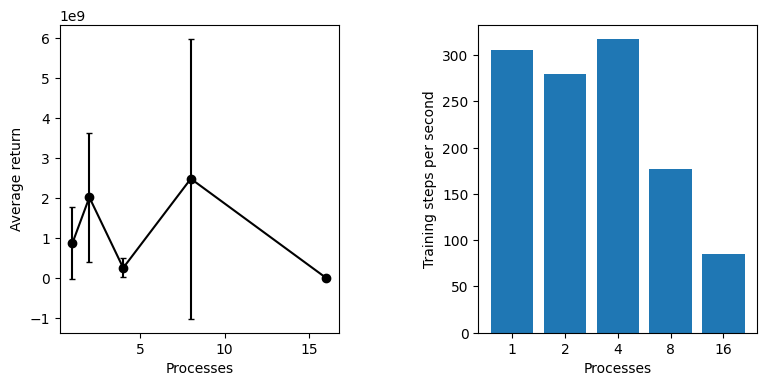

In [ ]:
training_steps_per_second = [TRAIN_STEPS / t for t in training_times]

plot_training_results(training_steps_per_second, reward_averages, reward_std)

In [ ]:
# The different number of processes that will be used


In [ ]:
model = PPO('MlpPolicy', env,
            verbose=0,
            learning_rate =0.002455056236483535,
            n_steps = 5,  #520
            batch_size = 512,
            gamma= 0.8897700488124874,
            gae_lambda=0.8757069936152605)
model.learn(total_timesteps=100000)
model.save('ppo_stock_trading')

/usr/local/lib/python3.10/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 512, but because the `RolloutBuffer` is of size `n_steps * n_envs = 20`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 20
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=5 and n_envs=4)
  warnings.warn(


In [ ]:
# Parameter sellect code
# import gymnasium as gym
# import optuna
# import pandas as pd
# from stable_baselines3 import PPO
# from stable_baselines3.common.env_util import make_vec_env
# from stable_baselines3.common.callbacks import EvalCallback
# from stable_baselines3.common.monitor import Monitor
# from gym import spaces
# import numpy as np


# def optimize_ppo(trial):
#     # 하이퍼파라미터를 Optuna의 trial 객체를 통해 샘플링
#     learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
#     n_steps = trial.suggest_int('n_steps', 128, 2048)
#     batch_size = trial.suggest_categorical('batch_size', [64, 128, 256, 512, 1024])
#     gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
#     gae_lambda = trial.suggest_uniform('gae_lambda', 0.8, 0.99)

#     # 환경 생성
#     # data = pd.read_csv('daily_stock_prices.csv')  # 데이터 불러오기

#     train_env = make_vec_env(make_env(df, rank=0), n_envs=n_envs)
#     eval_env = Monitor(StockPortfolioEnv(df))

#     # PPO 모델 생성
#     model = PPO(
#         "MlpPolicy",
#         train_env,
#         learning_rate=learning_rate,
#         n_steps=n_steps,
#         batch_size=batch_size,
#         gamma=gamma,
#         gae_lambda=gae_lambda,
#         verbose=0
#     )

    # 아래는 기존에 생성한 env임, 비교 평가를 위해서 넣음
    #env = make_vec_env(make_env(df, rank=0), n_envs=n_envs)
    # 평가 환경 설정
    # eval_callback = EvalCallback(eval_env, eval_freq=500, n_eval_episodes=50, verbose=0)

    # 모델 학습
    # model.learn(total_timesteps=5000, callback=eval_callback)

    # 마지막 평가에서의 평균 보상 반환
    # mean_reward = eval_callback.last_mean_reward
    # return mean_reward

# study = optuna.create_study(direction='maximize')
# study.optimize(optimize_ppo, n_trials=50)

# print("Best trial:")
# trial = study.best_trial
# print(f"Value: {trial.value}")
# print("Params: ")
# for key, value in trial.params.items():
#     print(f"{key}: {value}")

In [ ]:
# Best trial:
# Value: 7535583987.41942
# Params:
# learning_rate: 0.0024550562364583535
# n_steps: 590
# batch_size: 512
# gamma: 0.8897700488124874
# gae_lambda: 0.8757069936152605

In [ ]:
# Tensorboard logging check when model learning.
# from stable_baselines3.common.logger import configure

# # 텐서보드 로거 설정
# log_path = "./ppo_stock_trading_logs2/"
# new_logger = configure(log_path, ["stdout", "tensorboard"])
# model.set_logger(new_logger)

# # 텐서보드에서 학습 로그를 확인하려면, 아래 명령어를 실행하세요.
# # !tensorboard --logdir=./ppo_stock_trading_logs/

# # 학습 시작 및 로그 확인 가능
# model.learn(total_timesteps=10000000000)